# Label Efficiency test


In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')
path = "/content/drive/My Drive/CSC2503-Project"
os.chdir(path)

Mounted at /content/drive


## Train utility functions

In [3]:
"""Training Utility functions"""
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import timm

import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score


# Optimizer / Scheduler
def param_groups(model, weight_decay=0.05):
    """ Add weight decay on non-bias or non-LayerNorm, BatchNorm weights"""
    decay, no_decay = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or n.endswith(".bias"):  # bias or LayerNorm/BatchNorm weights
            no_decay.append(p)
        else:
            decay.append(p)
    return [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ]


# Training / Evaluation loops
def train_one_epoch(model, loader, optimizer, scaler, epoch, max_norm=1.0):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    pbar = tqdm(loader, desc=f"Train {epoch}", leave=False)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision training
        with autocast('cuda'):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        if max_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()

        preds = logits.argmax(1)
        running_loss += loss.item() * imgs.size(0)
        running_correct += (preds == labels).sum().item()
        total += imgs.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=running_correct/total)

    return running_loss / total, running_correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        with autocast('cuda'):
            logits = model(imgs)
            loss = criterion(logits, labels)
        preds = logits.argmax(1)
        running_loss += loss.item() * imgs.size(0)
        running_correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss / total, running_correct / total

def eval_on_test(model, test_loader):
  # Evaluation on the test set
  model.eval()
  total_loss = 0.0
  total_correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for imgs, labels in test_loader:
          imgs, labels = imgs.to(device), labels.to(device)
          logits = model(imgs)
          preds = logits.argmax(1)

          total_correct += (preds == labels).sum().item()
          total += imgs.size(0)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  accuracy = total_correct / total
  precision = precision_score(all_labels, all_preds, average='macro')
  recall = recall_score(all_labels, all_preds, average='macro')
  f1 = f1_score(all_labels, all_preds, average='macro')

  print(f"Test accuracy: {accuracy:.4f}")
  print(f"Precision (macro): {precision:.4f}")
  print(f"Recall (macro): {recall:.4f}")
  print(f"F1-score (macro): {f1:.4f}")

def visualize_attention_map(img, model):
  """Visualize attention map"""
  x = img.unsqueeze(0) # [1, 3, H, W]
  x = x.to(device)

  IMG_SIZE = x.shape[-1] # H = W
  patch = model.patch_embed.patch_size[0]

  # ---- Run through all but the last block; capture tokens pre-last-attn ----
  with torch.no_grad():
      # Patch embed + pos embed (+ optional pre-norm) like timm's forward_features
      x_tok = model.patch_embed(x)              # [B, Np, C]   (no cls yet)
      x_tok = model._pos_embed(x_tok)           # adds cls token & pos emb if present

      # Check if x_tok is a tuple and extract the tensor if it is
      if isinstance(x_tok, tuple):
          x_tok = x_tok[0]
      if hasattr(model, "pos_drop"):
          x_tok = model.pos_drop(x_tok)
      if hasattr(model, "norm_pre") and model.norm_pre is not None:
          x_tok = model.norm_pre(x_tok)

      # Forward through blocks except the last
      for blk in model.blocks[:-1]:
          x_tok = blk(x_tok)

      last_blk = model.blocks[-1]

      # ---- Compute attention of the last block explicitly ----
      # In a ViT block: y = x + Attn(LN1(x)), so the attention takes LN1(x) as input
      x_norm = last_blk.norm1(x_tok)

      # QKV projection
      B, N, C = x_norm.shape
      qkv = last_blk.attn.qkv(x_norm)  # [B, N, 3*C]
      num_heads = last_blk.attn.num_heads
      head_dim = C // num_heads
      scale = 1.0 / math.sqrt(head_dim)

      qkv = qkv.reshape(B, N, 3, num_heads, head_dim).permute(2, 0, 3, 1, 4)   # [3,B,H,N,D]
      q, k, v = qkv[0], qkv[1], qkv[2]                                         # each [B,H,N,D]

      attn = (q * scale) @ k.transpose(-2, -1)                                 # [B,H,N,N]
      attn = attn.softmax(dim=-1)                                              # prob over keys

      # ---- Reshape to patch grid and upsample to image size ----
      H_p = W_p = IMG_SIZE // patch                 # e.g., 32x32 for 512 input
      Np = H_p * W_p

      # ---- CLS-to-patches attention map (average over heads) ----
      # CLS token is at index 0; keep only patch tokens by slicing from (N - Np) onwards
      attn_cls = attn[:, :, 0, (N - Np):]                                      # [B, H, Np]
      attn_map = attn_cls.max(1).values

      # robust: patches are the *last* Np tokens in the sequence
      attn_map = attn_map.reshape(B, 1, H_p, W_p) # [B,1,H_p,W_p]
      attn_map = F.interpolate(attn_map, size=(IMG_SIZE, IMG_SIZE), mode="bicubic", align_corners=False)
      attn_map = attn_map[0,0] # [H, W]
      # Normalize for visualization
      attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-6)

  # ---- Plot overlay ----
  plt.figure(figsize=(8,8))
  img_np = x[0].cpu().permute(1, 2, 0).numpy()
  plt.imshow(img_np)
  plt.imshow(attn_map.cpu(), cmap='jet', alpha=0.6)
  plt.axis('off')
  plt.tight_layout()
  plt.show()



# Models

In [30]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

Using device: cuda


In [52]:
def dino_model(backbone='vit_small_patch16_dinov3',
               pretrained=True,
               num_classes=10,
               unfreeze_last_n=3,
               device=device):
  """DINO - unfreeze last 3 blocks"""
  # ViT - small ~ 22m parameters
  model = timm.create_model(
      backbone,
      pretrained=pretrained,
  )

  # Replace classifier head
  model.reset_classifier(num_classes=num_classes)
  model = model.to(device)

  # Unfreeze the last n blocks
  for p in model.parameters():
      p.requires_grad = False

  if unfreeze_last_n != 0:
    for block in model.blocks[-unfreeze_last_n:]:
        for p in block.parameters():
            p.requires_grad = True
  for p in model.get_classifier().parameters():
      p.requires_grad = True

  return model

def vit_model(backbone='vit_small_patch16_224',
               pretrained=True,
               num_classes=10,
               unfreeze_last_n=3,
               device=device):
  """ViT - unfreeze last 3 blocks"""
  # ViT - small ~ 22m parameters
  model = timm.create_model(
      backbone,
      pretrained=pretrained,
  )

  # Replace classifier head
  model.reset_classifier(num_classes=num_classes)
  model = model.to(device)

  # Unfreeze the last n blocks
  for p in model.parameters():
      p.requires_grad = False

  if unfreeze_last_n != 0:
    for block in model.blocks[-unfreeze_last_n:]:
        for p in block.parameters():
            p.requires_grad = True
  for p in model.get_classifier().parameters():
      p.requires_grad = True

  return model

# Load dataset of different sizes

In [49]:
cfg.batch_size = 32
cfg.num_workers = 4
cfg.use_bbox = False
cfg.train_ratios = [0.05, 0.1, 0.25, 0.5, 1]
cfg.random_seed = 42

cfg.lr = 5e-4
cfg.epochs = 20

## DINO

Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Balanced sampling: 8 samples per class × 10 classes = 80 total samples
Sampled 80/1600 samples (5.0%) for train split
Class distribution: {'A': 8, 'B': 8, 'C': 8, 'D': 8, 'E': 8, 'F': 8, 'H': 8, 'I': 8, 'J': 8, 'K': 8}


Epoch 01: train_loss=2.3838 train_acc=0.0250 | val_loss=2.2839 val_acc=0.1375


Epoch 02: train_loss=2.1620 train_acc=0.3375 | val_loss=2.2351 val_acc=0.2875


Epoch 03: train_loss=1.9536 train_acc=0.5375 | val_loss=2.1079 val_acc=0.3225


Epoch 04: train_loss=1.6227 train_acc=0.6375 | val_loss=1.8028 val_acc=0.4900


Epoch 05: train_loss=1.2248 train_acc=0.8125 | val_loss=1.4953 val_acc=0.5550


Epoch 06: train_loss=0.8627 train_acc=0.8625 | val_loss=1.3079 val_acc=0.6000


Epoch 07: train_loss=0.5949 train_acc=0.9625 | val_loss=1.1075 val_acc=0.7075


Epoch 08: train_loss=0.4112 train_acc=0.9750 | val_loss=0.9538 val_acc=0.7200


Epoch 09: train_loss=0.2643 train_acc=1.0000 | val_loss=0.9492 val_acc=0.7150


Epoch 10: train_loss=0.1884 train_acc=1.0000 | val_loss=0.8523 val_acc=0.7225


Epoch 11: train_loss=0.1266 train_acc=1.0000 | val_loss=0.7993 val_acc=0.7175


Epoch 12: train_loss=0.0985 train_acc=1.0000 | val_loss=0.7433 val_acc=0.7625


Epoch 13: train_loss=0.0744 train_acc=1.0000 | val_loss=0.7412 val_acc=0.7825


Epoch 14: train_loss=0.0650 train_acc=1.0000 | val_loss=0.7476 val_acc=0.7725


Epoch 15: train_loss=0.0578 train_acc=1.0000 | val_loss=0.7422 val_acc=0.7625


Epoch 16: train_loss=0.0523 train_acc=1.0000 | val_loss=0.7392 val_acc=0.7575


Epoch 17: train_loss=0.0494 train_acc=1.0000 | val_loss=0.7363 val_acc=0.7625


Epoch 18: train_loss=0.0478 train_acc=1.0000 | val_loss=0.7333 val_acc=0.7600


Epoch 19: train_loss=0.0469 train_acc=1.0000 | val_loss=0.7315 val_acc=0.7575


Epoch 20: train_loss=0.0466 train_acc=1.0000 | val_loss=0.7309 val_acc=0.7575
Saved best model with val_acc=0.7825 to best_name


Test accuracy: 0.7290
Precision (macro): 0.7458
Recall (macro): 0.7290
F1-score (macro): 0.7057


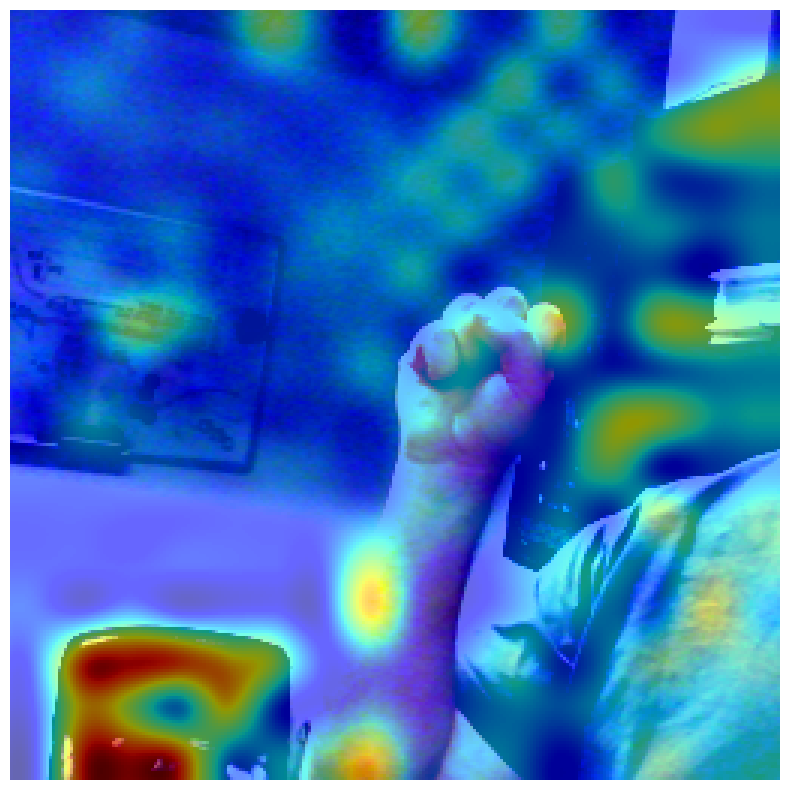

Balanced sampling: 16 samples per class × 10 classes = 160 total samples
Sampled 160/1600 samples (10.0%) for train split
Class distribution: {'A': 16, 'B': 16, 'C': 16, 'D': 16, 'E': 16, 'F': 16, 'H': 16, 'I': 16, 'J': 16, 'K': 16}


Epoch 01: train_loss=2.3518 train_acc=0.0688 | val_loss=2.2869 val_acc=0.1650


Epoch 02: train_loss=2.1613 train_acc=0.2875 | val_loss=2.2008 val_acc=0.2500


Epoch 03: train_loss=1.7914 train_acc=0.5750 | val_loss=1.6986 val_acc=0.5250


Epoch 04: train_loss=1.2032 train_acc=0.7875 | val_loss=1.2213 val_acc=0.6125


Epoch 05: train_loss=0.7423 train_acc=0.9250 | val_loss=0.8965 val_acc=0.7450


Epoch 06: train_loss=0.4443 train_acc=0.9812 | val_loss=0.6787 val_acc=0.8000


Epoch 07: train_loss=0.2436 train_acc=0.9938 | val_loss=0.6655 val_acc=0.7625


Epoch 08: train_loss=0.1362 train_acc=1.0000 | val_loss=0.5324 val_acc=0.8125


Epoch 09: train_loss=0.0786 train_acc=1.0000 | val_loss=0.5484 val_acc=0.7975


Epoch 10: train_loss=0.0516 train_acc=1.0000 | val_loss=0.3925 val_acc=0.8750


Epoch 11: train_loss=0.0382 train_acc=1.0000 | val_loss=0.3531 val_acc=0.8850


Epoch 12: train_loss=0.0302 train_acc=1.0000 | val_loss=0.3594 val_acc=0.8750


Epoch 13: train_loss=0.0256 train_acc=1.0000 | val_loss=0.3886 val_acc=0.8550


Epoch 14: train_loss=0.0231 train_acc=1.0000 | val_loss=0.3841 val_acc=0.8525


Epoch 15: train_loss=0.0215 train_acc=1.0000 | val_loss=0.3696 val_acc=0.8575


Epoch 16: train_loss=0.0205 train_acc=1.0000 | val_loss=0.3581 val_acc=0.8625


Epoch 17: train_loss=0.0199 train_acc=1.0000 | val_loss=0.3509 val_acc=0.8625


Epoch 18: train_loss=0.0195 train_acc=1.0000 | val_loss=0.3472 val_acc=0.8625


Epoch 19: train_loss=0.0194 train_acc=1.0000 | val_loss=0.3460 val_acc=0.8625


Epoch 20: train_loss=0.0193 train_acc=1.0000 | val_loss=0.3458 val_acc=0.8625
Saved best model with val_acc=0.8850 to best_name


Test accuracy: 0.8370
Precision (macro): 0.8569
Recall (macro): 0.8370
F1-score (macro): 0.8393


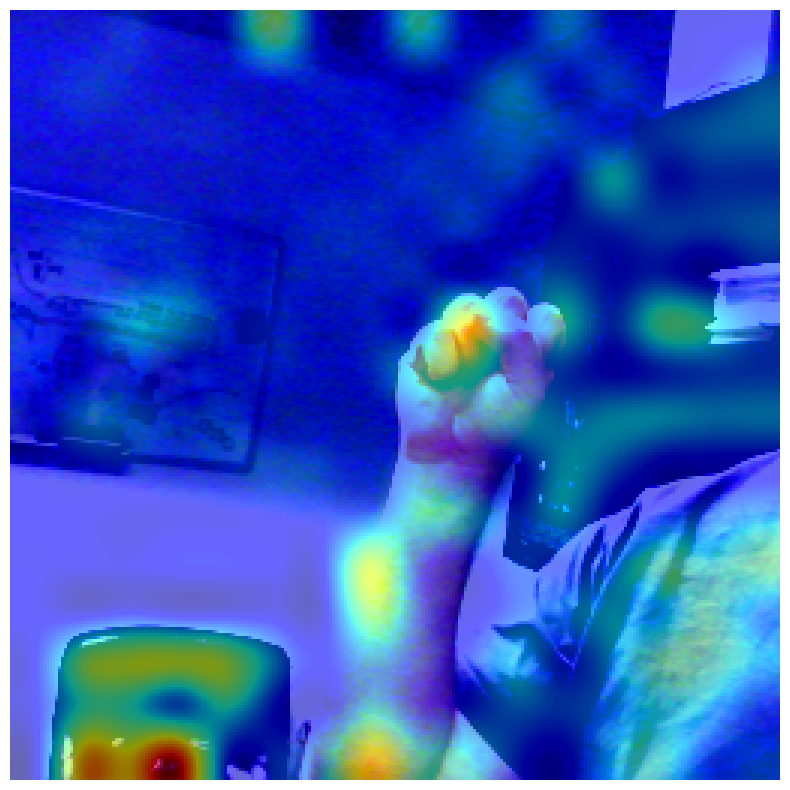

Balanced sampling: 40 samples per class × 10 classes = 400 total samples
Sampled 400/1600 samples (25.0%) for train split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}


Epoch 01: train_loss=2.1447 train_acc=0.2225 | val_loss=1.5595 val_acc=0.5925


Epoch 02: train_loss=1.0421 train_acc=0.7450 | val_loss=0.7071 val_acc=0.8575


Epoch 03: train_loss=0.3552 train_acc=0.9525 | val_loss=0.3003 val_acc=0.9475


Epoch 04: train_loss=0.1037 train_acc=0.9950 | val_loss=0.1371 val_acc=0.9775


Epoch 05: train_loss=0.0359 train_acc=1.0000 | val_loss=0.1700 val_acc=0.9300


Epoch 06: train_loss=0.0159 train_acc=1.0000 | val_loss=0.0919 val_acc=0.9700


Epoch 07: train_loss=0.0109 train_acc=1.0000 | val_loss=0.0909 val_acc=0.9775


Epoch 08: train_loss=0.0082 train_acc=1.0000 | val_loss=0.0909 val_acc=0.9725


Epoch 09: train_loss=0.0069 train_acc=1.0000 | val_loss=0.0775 val_acc=0.9725


Epoch 10: train_loss=0.0062 train_acc=1.0000 | val_loss=0.0769 val_acc=0.9750


Epoch 11: train_loss=0.0057 train_acc=1.0000 | val_loss=0.0744 val_acc=0.9750


Epoch 12: train_loss=0.0053 train_acc=1.0000 | val_loss=0.0747 val_acc=0.9750


Epoch 13: train_loss=0.0051 train_acc=1.0000 | val_loss=0.0744 val_acc=0.9750


Epoch 14: train_loss=0.0049 train_acc=1.0000 | val_loss=0.0742 val_acc=0.9750


Epoch 15: train_loss=0.0047 train_acc=1.0000 | val_loss=0.0729 val_acc=0.9750


Epoch 16: train_loss=0.0046 train_acc=1.0000 | val_loss=0.0723 val_acc=0.9750


Epoch 17: train_loss=0.0045 train_acc=1.0000 | val_loss=0.0723 val_acc=0.9750


Epoch 18: train_loss=0.0045 train_acc=1.0000 | val_loss=0.0723 val_acc=0.9750


Epoch 19: train_loss=0.0044 train_acc=1.0000 | val_loss=0.0724 val_acc=0.9750


Epoch 20: train_loss=0.0044 train_acc=1.0000 | val_loss=0.0723 val_acc=0.9750
Saved best model with val_acc=0.9775 to best_name


Test accuracy: 0.9230
Precision (macro): 0.9248
Recall (macro): 0.9230
F1-score (macro): 0.9236


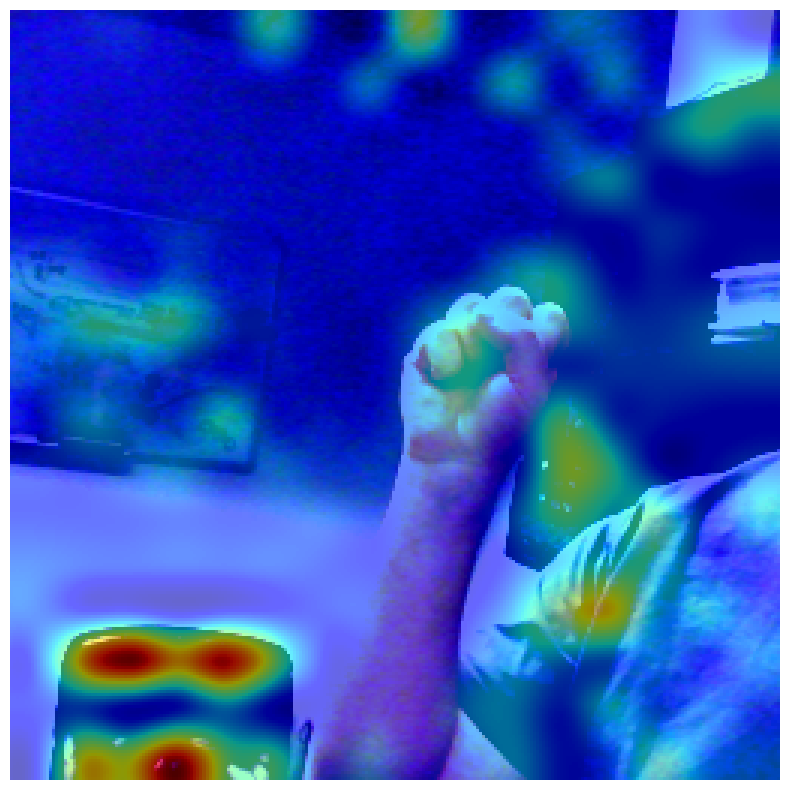

Balanced sampling: 80 samples per class × 10 classes = 800 total samples
Sampled 800/1600 samples (50.0%) for train split
Class distribution: {'A': 80, 'B': 80, 'C': 80, 'D': 80, 'E': 80, 'F': 80, 'H': 80, 'I': 80, 'J': 80, 'K': 80}


Epoch 01: train_loss=1.5684 train_acc=0.5050 | val_loss=0.7422 val_acc=0.7825


Epoch 02: train_loss=0.2653 train_acc=0.9725 | val_loss=0.0949 val_acc=0.9975


Epoch 03: train_loss=0.0325 train_acc=0.9988 | val_loss=0.0492 val_acc=0.9875


Epoch 04: train_loss=0.0140 train_acc=1.0000 | val_loss=0.0338 val_acc=0.9925


Epoch 05: train_loss=0.0084 train_acc=1.0000 | val_loss=0.0573 val_acc=0.9850


Epoch 06: train_loss=0.0049 train_acc=1.0000 | val_loss=0.0306 val_acc=0.9925


Epoch 07: train_loss=0.0038 train_acc=1.0000 | val_loss=0.0309 val_acc=0.9925


Epoch 08: train_loss=0.0033 train_acc=1.0000 | val_loss=0.0297 val_acc=0.9925


Epoch 09: train_loss=0.0029 train_acc=1.0000 | val_loss=0.0285 val_acc=0.9925


Epoch 10: train_loss=0.0026 train_acc=1.0000 | val_loss=0.0283 val_acc=0.9925


Epoch 11: train_loss=0.0024 train_acc=1.0000 | val_loss=0.0280 val_acc=0.9925


Epoch 12: train_loss=0.0023 train_acc=1.0000 | val_loss=0.0273 val_acc=0.9925


Epoch 13: train_loss=0.0021 train_acc=1.0000 | val_loss=0.0270 val_acc=0.9925


Epoch 14: train_loss=0.0021 train_acc=1.0000 | val_loss=0.0270 val_acc=0.9925


Epoch 15: train_loss=0.0020 train_acc=1.0000 | val_loss=0.0272 val_acc=0.9925


Epoch 16: train_loss=0.0019 train_acc=1.0000 | val_loss=0.0270 val_acc=0.9925


Epoch 17: train_loss=0.0019 train_acc=1.0000 | val_loss=0.0268 val_acc=0.9925


Epoch 18: train_loss=0.0019 train_acc=1.0000 | val_loss=0.0268 val_acc=0.9925


Epoch 19: train_loss=0.0019 train_acc=1.0000 | val_loss=0.0268 val_acc=0.9925


Epoch 20: train_loss=0.0019 train_acc=1.0000 | val_loss=0.0268 val_acc=0.9925
Saved best model with val_acc=0.9975 to best_name


Test accuracy: 0.9560
Precision (macro): 0.9586
Recall (macro): 0.9560
F1-score (macro): 0.9564


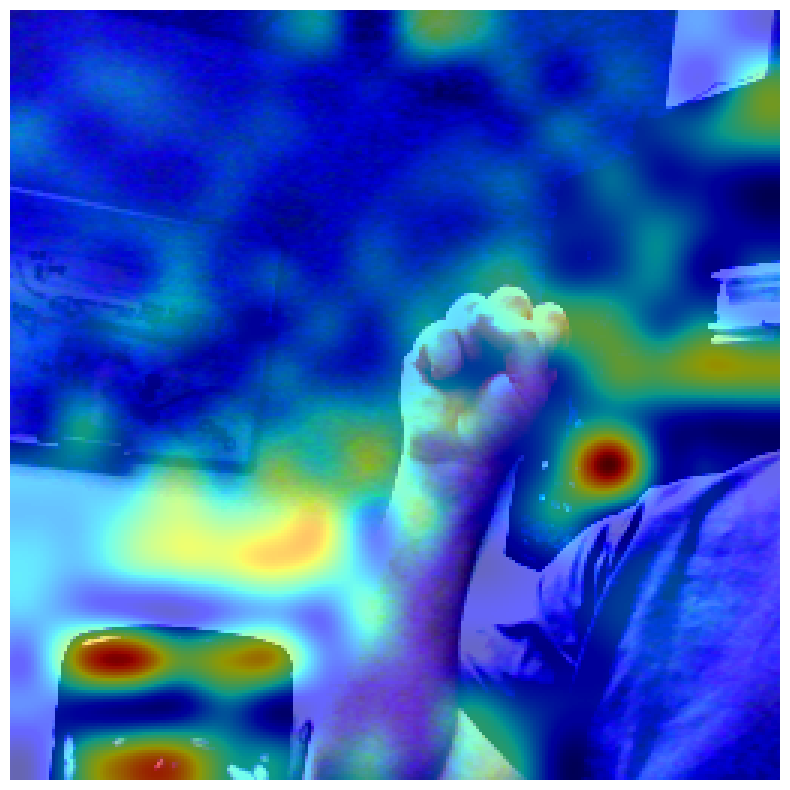

In [34]:
import torch
import timm
from torch.utils.data import DataLoader
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from torchvision import transforms
import torch.nn as nn

from ouhands_loader import OuhandsDS

dino_model_name = 'vit_small_patch16_dinov3'
model = timm.create_model(
    dino_model_name,
    pretrained=True,
)

# Get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**data_config, is_training=False)

val_ds = OuhandsDS(split='validation',
                   transform=transform,
                   use_bounding_box=cfg.use_bbox)
test_ds = OuhandsDS(split='test',
                    transform=transform,
                    use_bounding_box=cfg.use_bbox)

val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False
                        , num_workers=cfg.num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False
                          , num_workers=cfg.num_workers, pin_memory=True)

for train_ratio in cfg.train_ratios:
    # Sample x% of training set
    train_ds = OuhandsDS(split='train',
                        transform=transform,
                        use_bounding_box=cfg.use_bbox,
                        train_subset_ratio=train_ratio,
                        random_seed=cfg.random_seed)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True
                              ,  num_workers=cfg.num_workers, pin_memory=True)

    # Modeling
    model = dino_model()
    optimizer = AdamW(param_groups(model), lr=cfg.lr, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    scaler = GradScaler()

    # Training
    best_acc = 0.0
    best_state = None

    for epoch in range(1, cfg.epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, epoch)
        val_loss, val_acc = evaluate(model, val_loader)
        scheduler.step()

        print(f"Epoch {epoch:02d}: "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    if best_state is not None:
        best_name = f"{dino_model_name}_{int(train_ratio * 100)}percent_label.pt"
        torch.save(best_state, f"./checkpoints/{best_name}")
        print(f"Saved best model with val_acc={best_acc:.4f} to best_name")

    eval_on_test(model, test_loader)
    visualize_attention_map(train_ds[0][0], model)

## ViT - Finetuned

In [50]:
model_name = 'vit_small_patch16_224'

temp_model_for_config = timm.create_model(model_name, pretrained=True)

# 224 x 224
data_config = timm.data.resolve_model_data_config(temp_model_for_config)
transform = timm.data.create_transform(**data_config, is_training=False)

val_ds = OuhandsDS(split='validation',
                   transform=transform,
                   use_bounding_box=cfg.use_bbox)
test_ds = OuhandsDS(split='test',
                    transform=transform,
                    use_bounding_box=cfg.use_bbox)

val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False
                        , num_workers=cfg.num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False
                          , num_workers=cfg.num_workers, pin_memory=True)

for train_ratio in cfg.train_ratios:
    # Sample x% of training set
    train_ds = OuhandsDS(split='train',
                        transform=transform,
                        use_bounding_box=cfg.use_bbox,
                        train_subset_ratio=train_ratio,
                        random_seed=cfg.random_seed)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True
                              ,  num_workers=cfg.num_workers, pin_memory=True)

    # Modeling: Now vit_model() correctly refers to the function
    model = vit_model()
    optimizer = AdamW(param_groups(model), lr=cfg.lr, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    scaler = GradScaler()

    # Training
    best_acc = 0.0
    best_state = None

    for epoch in range(1, cfg.epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, epoch)
        val_loss, val_acc = evaluate(model, val_loader)
        scheduler.step()

        print(f"Epoch {epoch:02d}: "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    if best_state is not None:
        best_name = f"{model_name}_{int(train_ratio * 100)}percent_label.pt"
        torch.save(best_state, f"./checkpoints/{best_name}")
        print(f"Saved best model with val_acc={best_acc:.4f} to best_name")

    eval_on_test(model, test_loader)
    # visualize_attention_map(train_ds[0][0], model)


Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Balanced sampling: 8 samples per class × 10 classes = 80 total samples
Sampled 80/1600 samples (5.0%) for train split
Class distribution: {'A': 8, 'B': 8, 'C': 8, 'D': 8, 'E': 8, 'F': 8, 'H': 8, 'I': 8, 'J': 8, 'K': 8}


Epoch 01: train_loss=3.0076 train_acc=0.0875 | val_loss=3.9103 val_acc=0.1325


Epoch 02: train_loss=3.5334 train_acc=0.2375 | val_loss=3.1315 val_acc=0.1250


Epoch 03: train_loss=1.1533 train_acc=0.6250 | val_loss=2.6177 val_acc=0.1700


Epoch 04: train_loss=0.4183 train_acc=0.9000 | val_loss=2.8957 val_acc=0.1900


Epoch 05: train_loss=0.0509 train_acc=1.0000 | val_loss=3.7164 val_acc=0.1975


Epoch 06: train_loss=0.0100 train_acc=1.0000 | val_loss=3.8015 val_acc=0.1850


Epoch 07: train_loss=0.0024 train_acc=1.0000 | val_loss=3.7617 val_acc=0.2050


Epoch 08: train_loss=0.0010 train_acc=1.0000 | val_loss=3.8627 val_acc=0.1925


Epoch 09: train_loss=0.0007 train_acc=1.0000 | val_loss=3.9533 val_acc=0.2025


Epoch 10: train_loss=0.0005 train_acc=1.0000 | val_loss=4.0023 val_acc=0.2025


Epoch 11: train_loss=0.0004 train_acc=1.0000 | val_loss=4.0288 val_acc=0.2025


Epoch 12: train_loss=0.0003 train_acc=1.0000 | val_loss=4.0430 val_acc=0.2050


Epoch 13: train_loss=0.0003 train_acc=1.0000 | val_loss=4.0505 val_acc=0.2050


Epoch 14: train_loss=0.0002 train_acc=1.0000 | val_loss=4.0535 val_acc=0.2075


Epoch 15: train_loss=0.0002 train_acc=1.0000 | val_loss=4.0551 val_acc=0.2025


Epoch 16: train_loss=0.0002 train_acc=1.0000 | val_loss=4.0559 val_acc=0.2025


Epoch 17: train_loss=0.0002 train_acc=1.0000 | val_loss=4.0562 val_acc=0.2025


Epoch 18: train_loss=0.0002 train_acc=1.0000 | val_loss=4.0562 val_acc=0.2050


Epoch 19: train_loss=0.0002 train_acc=1.0000 | val_loss=4.0561 val_acc=0.2025


Epoch 20: train_loss=0.0002 train_acc=1.0000 | val_loss=4.0562 val_acc=0.2025
Saved best model with val_acc=0.2075 to best_name
Test accuracy: 0.2040
Precision (macro): 0.2182
Recall (macro): 0.2040
F1-score (macro): 0.1732
Balanced sampling: 16 samples per class × 10 classes = 160 total samples
Sampled 160/1600 samples (10.0%) for train split
Class distribution: {'A': 16, 'B': 16, 'C': 16, 'D': 16, 'E': 16, 'F': 16, 'H': 16, 'I': 16, 'J': 16, 'K': 16}


Epoch 01: train_loss=3.6783 train_acc=0.0938 | val_loss=3.8804 val_acc=0.1225


Epoch 02: train_loss=2.7900 train_acc=0.2812 | val_loss=2.1592 val_acc=0.2200


Epoch 03: train_loss=1.2574 train_acc=0.5938 | val_loss=1.8443 val_acc=0.3050


Epoch 04: train_loss=0.4424 train_acc=0.8750 | val_loss=2.0572 val_acc=0.3425


Epoch 05: train_loss=0.1122 train_acc=0.9812 | val_loss=2.3007 val_acc=0.3625


Epoch 06: train_loss=0.0234 train_acc=0.9938 | val_loss=2.1602 val_acc=0.4050


Epoch 07: train_loss=0.0043 train_acc=1.0000 | val_loss=2.0400 val_acc=0.4375


Epoch 08: train_loss=0.0024 train_acc=1.0000 | val_loss=2.1406 val_acc=0.4350


Epoch 09: train_loss=0.0007 train_acc=1.0000 | val_loss=2.2705 val_acc=0.4350


Epoch 10: train_loss=0.0003 train_acc=1.0000 | val_loss=2.3352 val_acc=0.4150


Epoch 11: train_loss=0.0003 train_acc=1.0000 | val_loss=2.3575 val_acc=0.4075


Epoch 12: train_loss=0.0002 train_acc=1.0000 | val_loss=2.3561 val_acc=0.4150


Epoch 13: train_loss=0.0002 train_acc=1.0000 | val_loss=2.3477 val_acc=0.4150


Epoch 14: train_loss=0.0002 train_acc=1.0000 | val_loss=2.3398 val_acc=0.4125


Epoch 15: train_loss=0.0002 train_acc=1.0000 | val_loss=2.3329 val_acc=0.4125


Epoch 16: train_loss=0.0002 train_acc=1.0000 | val_loss=2.3286 val_acc=0.4125


Epoch 17: train_loss=0.0001 train_acc=1.0000 | val_loss=2.3259 val_acc=0.4150


Epoch 18: train_loss=0.0001 train_acc=1.0000 | val_loss=2.3245 val_acc=0.4150


Epoch 19: train_loss=0.0001 train_acc=1.0000 | val_loss=2.3238 val_acc=0.4150


Epoch 20: train_loss=0.0001 train_acc=1.0000 | val_loss=2.3235 val_acc=0.4150
Saved best model with val_acc=0.4375 to best_name
Test accuracy: 0.4080
Precision (macro): 0.4230
Recall (macro): 0.4080
F1-score (macro): 0.3907
Balanced sampling: 40 samples per class × 10 classes = 400 total samples
Sampled 400/1600 samples (25.0%) for train split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}


Epoch 01: train_loss=2.8306 train_acc=0.2425 | val_loss=1.5518 val_acc=0.4650


Epoch 02: train_loss=0.8666 train_acc=0.6950 | val_loss=0.9695 val_acc=0.6325


Epoch 03: train_loss=0.4531 train_acc=0.8750 | val_loss=0.8705 val_acc=0.6825


Epoch 04: train_loss=0.1332 train_acc=0.9475 | val_loss=1.2627 val_acc=0.6775


Epoch 05: train_loss=0.1436 train_acc=0.9400 | val_loss=0.7098 val_acc=0.7750


Epoch 06: train_loss=0.0641 train_acc=0.9750 | val_loss=0.9302 val_acc=0.7300


Epoch 07: train_loss=0.0523 train_acc=0.9825 | val_loss=0.8944 val_acc=0.7650


Epoch 08: train_loss=0.0474 train_acc=0.9850 | val_loss=0.8415 val_acc=0.8025


Epoch 09: train_loss=0.0109 train_acc=0.9975 | val_loss=0.6508 val_acc=0.8200


Epoch 10: train_loss=0.0010 train_acc=1.0000 | val_loss=0.6990 val_acc=0.8000


Epoch 11: train_loss=0.0004 train_acc=1.0000 | val_loss=0.8251 val_acc=0.7700


Epoch 12: train_loss=0.0002 train_acc=1.0000 | val_loss=0.7269 val_acc=0.7850


Epoch 13: train_loss=0.0001 train_acc=1.0000 | val_loss=0.7029 val_acc=0.7950


Epoch 14: train_loss=0.0001 train_acc=1.0000 | val_loss=0.7058 val_acc=0.7950


Epoch 15: train_loss=0.0001 train_acc=1.0000 | val_loss=0.7090 val_acc=0.7950


Epoch 16: train_loss=0.0001 train_acc=1.0000 | val_loss=0.7139 val_acc=0.7950


Epoch 17: train_loss=0.0001 train_acc=1.0000 | val_loss=0.7151 val_acc=0.7975


Epoch 18: train_loss=0.0001 train_acc=1.0000 | val_loss=0.7153 val_acc=0.7975


Epoch 19: train_loss=0.0001 train_acc=1.0000 | val_loss=0.7158 val_acc=0.7975


Epoch 20: train_loss=0.0001 train_acc=1.0000 | val_loss=0.7158 val_acc=0.7975
Saved best model with val_acc=0.8200 to best_name
Test accuracy: 0.7500
Precision (macro): 0.7701
Recall (macro): 0.7500
F1-score (macro): 0.7503
Balanced sampling: 80 samples per class × 10 classes = 800 total samples
Sampled 800/1600 samples (50.0%) for train split
Class distribution: {'A': 80, 'B': 80, 'C': 80, 'D': 80, 'E': 80, 'F': 80, 'H': 80, 'I': 80, 'J': 80, 'K': 80}


Epoch 01: train_loss=2.3996 train_acc=0.3387 | val_loss=1.1443 val_acc=0.5650


Epoch 02: train_loss=0.5206 train_acc=0.8137 | val_loss=0.6387 val_acc=0.7525


Epoch 03: train_loss=0.1849 train_acc=0.9375 | val_loss=0.6855 val_acc=0.8125


Epoch 04: train_loss=0.1146 train_acc=0.9587 | val_loss=0.8571 val_acc=0.7800


Epoch 05: train_loss=0.0707 train_acc=0.9688 | val_loss=0.9676 val_acc=0.7800


Epoch 06: train_loss=0.0928 train_acc=0.9762 | val_loss=1.2442 val_acc=0.7675


Epoch 07: train_loss=0.0289 train_acc=0.9925 | val_loss=1.1647 val_acc=0.7550


Epoch 08: train_loss=0.0168 train_acc=0.9938 | val_loss=0.7899 val_acc=0.8600


Epoch 09: train_loss=0.0027 train_acc=1.0000 | val_loss=0.6416 val_acc=0.8600


Epoch 10: train_loss=0.0012 train_acc=1.0000 | val_loss=1.1298 val_acc=0.8575


Epoch 11: train_loss=0.0034 train_acc=0.9988 | val_loss=0.6133 val_acc=0.8825


Epoch 12: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6643 val_acc=0.8875


Epoch 13: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6624 val_acc=0.8875


Epoch 14: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6584 val_acc=0.8875


Epoch 15: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6568 val_acc=0.8875


Epoch 16: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6548 val_acc=0.8875


Epoch 17: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6540 val_acc=0.8875


Epoch 18: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6538 val_acc=0.8875


Epoch 19: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6536 val_acc=0.8875


Epoch 20: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6534 val_acc=0.8875
Saved best model with val_acc=0.8875 to best_name
Test accuracy: 0.7750
Precision (macro): 0.8027
Recall (macro): 0.7750
F1-score (macro): 0.7774
Loaded 1600 samples for train split
Class distribution: {'A': 160, 'B': 160, 'C': 160, 'D': 160, 'E': 160, 'F': 160, 'H': 160, 'I': 160, 'J': 160, 'K': 160}


Epoch 01: train_loss=1.5246 train_acc=0.5244 | val_loss=0.8792 val_acc=0.7200


Epoch 02: train_loss=0.2778 train_acc=0.9012 | val_loss=0.6552 val_acc=0.8075


Epoch 03: train_loss=0.1248 train_acc=0.9575 | val_loss=0.8525 val_acc=0.8150


Epoch 04: train_loss=0.1340 train_acc=0.9613 | val_loss=0.8368 val_acc=0.7950


Epoch 05: train_loss=0.0646 train_acc=0.9769 | val_loss=0.8399 val_acc=0.8050


Epoch 06: train_loss=0.0644 train_acc=0.9775 | val_loss=0.6756 val_acc=0.8425


Epoch 07: train_loss=0.0185 train_acc=0.9950 | val_loss=0.8092 val_acc=0.8475


Epoch 08: train_loss=0.0072 train_acc=0.9969 | val_loss=0.9032 val_acc=0.8400


Epoch 09: train_loss=0.0136 train_acc=0.9962 | val_loss=1.4358 val_acc=0.8125


Epoch 10: train_loss=0.0088 train_acc=0.9969 | val_loss=0.6291 val_acc=0.8875


Epoch 11: train_loss=0.0011 train_acc=1.0000 | val_loss=0.4742 val_acc=0.8900


Epoch 12: train_loss=0.0005 train_acc=0.9994 | val_loss=0.7709 val_acc=0.8850


Epoch 13: train_loss=0.0002 train_acc=1.0000 | val_loss=0.5451 val_acc=0.8875


Epoch 14: train_loss=0.0001 train_acc=1.0000 | val_loss=0.6129 val_acc=0.8925


Epoch 15: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6240 val_acc=0.8900


Epoch 16: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6230 val_acc=0.8900


Epoch 17: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6229 val_acc=0.8900


Epoch 18: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6226 val_acc=0.8900


Epoch 19: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6226 val_acc=0.8900


Epoch 20: train_loss=0.0000 train_acc=1.0000 | val_loss=0.6227 val_acc=0.8900
Saved best model with val_acc=0.8925 to best_name
Test accuracy: 0.8420
Precision (macro): 0.8481
Recall (macro): 0.8420
F1-score (macro): 0.8411


## Resnet34

In [48]:
model_name = 'resnet34'
temp_model_for_config = timm.create_model(model_name, pretrained=True)

# 224 x 224
data_config = timm.data.resolve_model_data_config(temp_model_for_config)
transform = timm.data.create_transform(**data_config, is_training=False)

val_ds = OuhandsDS(split='validation',
                   transform=transform,
                   use_bounding_box=cfg.use_bbox)
test_ds = OuhandsDS(split='test',
                    transform=transform,
                    use_bounding_box=cfg.use_bbox)

val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False
                        , num_workers=cfg.num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False
                          , num_workers=cfg.num_workers, pin_memory=True)

for train_ratio in cfg.train_ratios:
    # Sample x% of training set
    train_ds = OuhandsDS(split='train',
                        transform=transform,
                        use_bounding_box=cfg.use_bbox,
                        train_subset_ratio=train_ratio,
                        random_seed=cfg.random_seed)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True
                              ,  num_workers=cfg.num_workers, pin_memory=True)

    # Modeling: Now vit_model() correctly refers to the function
    model = timm.create_model('resnet34', num_classes=10, pretrained=True)
    model = model.to(device)
    optimizer = AdamW(param_groups(model), lr=cfg.lr, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    scaler = GradScaler()

    # Training
    best_acc = 0.0
    best_state = None

    for epoch in range(1, cfg.epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, epoch)
        val_loss, val_acc = evaluate(model, val_loader)
        scheduler.step()

        print(f"Epoch {epoch:02d}: "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    if best_state is not None:
        best_name = f"{model_name}_{int(train_ratio * 100)}percent_label.pt"
        torch.save(best_state, f"./checkpoints/{best_name}")
        print(f"Saved best model with val_acc={best_acc:.4f} to best_name")

    eval_on_test(model, test_loader)


Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Balanced sampling: 8 samples per class × 10 classes = 80 total samples
Sampled 80/1600 samples (5.0%) for train split
Class distribution: {'A': 8, 'B': 8, 'C': 8, 'D': 8, 'E': 8, 'F': 8, 'H': 8, 'I': 8, 'J': 8, 'K': 8}


Epoch 01: train_loss=2.2929 train_acc=0.1250 | val_loss=2.2913 val_acc=0.1100


Epoch 02: train_loss=2.1004 train_acc=0.4125 | val_loss=2.2812 val_acc=0.1625


Epoch 03: train_loss=1.9059 train_acc=0.8750 | val_loss=2.2739 val_acc=0.2075


Epoch 04: train_loss=1.7560 train_acc=0.9000 | val_loss=2.2655 val_acc=0.1850


Epoch 05: train_loss=1.5905 train_acc=0.9875 | val_loss=2.2492 val_acc=0.1900


Epoch 06: train_loss=1.4690 train_acc=1.0000 | val_loss=2.2338 val_acc=0.1825


Epoch 07: train_loss=1.3239 train_acc=1.0000 | val_loss=2.2172 val_acc=0.1950


Epoch 08: train_loss=1.2199 train_acc=1.0000 | val_loss=2.1986 val_acc=0.2100


Epoch 09: train_loss=1.1118 train_acc=1.0000 | val_loss=2.1861 val_acc=0.2100


Epoch 10: train_loss=0.9825 train_acc=1.0000 | val_loss=2.1738 val_acc=0.2275


Epoch 11: train_loss=0.9066 train_acc=1.0000 | val_loss=2.1591 val_acc=0.2400


Epoch 12: train_loss=0.8246 train_acc=1.0000 | val_loss=2.1519 val_acc=0.2425


Epoch 13: train_loss=0.7684 train_acc=1.0000 | val_loss=2.1443 val_acc=0.2475


Epoch 14: train_loss=0.7063 train_acc=1.0000 | val_loss=2.1322 val_acc=0.2725


Epoch 15: train_loss=0.6801 train_acc=1.0000 | val_loss=2.1258 val_acc=0.2850


Epoch 16: train_loss=0.6572 train_acc=1.0000 | val_loss=2.1208 val_acc=0.2850


Epoch 17: train_loss=0.6033 train_acc=1.0000 | val_loss=2.1156 val_acc=0.2850


Epoch 18: train_loss=0.6026 train_acc=1.0000 | val_loss=2.1143 val_acc=0.2950


Epoch 19: train_loss=0.6101 train_acc=1.0000 | val_loss=2.1115 val_acc=0.2850


Epoch 20: train_loss=0.5938 train_acc=1.0000 | val_loss=2.1121 val_acc=0.2925
Saved best model with val_acc=0.2950 to best_name
Test accuracy: 0.2360
Precision (macro): 0.2133
Recall (macro): 0.2360
F1-score (macro): 0.1985
Balanced sampling: 16 samples per class × 10 classes = 160 total samples
Sampled 160/1600 samples (10.0%) for train split
Class distribution: {'A': 16, 'B': 16, 'C': 16, 'D': 16, 'E': 16, 'F': 16, 'H': 16, 'I': 16, 'J': 16, 'K': 16}


Epoch 01: train_loss=2.3160 train_acc=0.1000 | val_loss=2.3012 val_acc=0.1350


Epoch 02: train_loss=2.1120 train_acc=0.5750 | val_loss=2.2738 val_acc=0.1425


Epoch 03: train_loss=1.9077 train_acc=0.9125 | val_loss=2.2426 val_acc=0.1875


Epoch 04: train_loss=1.7090 train_acc=0.9750 | val_loss=2.1898 val_acc=0.2650


Epoch 05: train_loss=1.5038 train_acc=1.0000 | val_loss=2.1452 val_acc=0.3000


Epoch 06: train_loss=1.3001 train_acc=0.9938 | val_loss=2.0850 val_acc=0.3525


Epoch 07: train_loss=1.0976 train_acc=1.0000 | val_loss=2.0053 val_acc=0.3900


Epoch 08: train_loss=0.9164 train_acc=1.0000 | val_loss=1.9171 val_acc=0.4500


Epoch 09: train_loss=0.7479 train_acc=1.0000 | val_loss=1.8429 val_acc=0.5075


Epoch 10: train_loss=0.6190 train_acc=1.0000 | val_loss=1.7749 val_acc=0.5025


Epoch 11: train_loss=0.4926 train_acc=1.0000 | val_loss=1.7156 val_acc=0.5325


Epoch 12: train_loss=0.4016 train_acc=1.0000 | val_loss=1.6551 val_acc=0.5525


Epoch 13: train_loss=0.3400 train_acc=1.0000 | val_loss=1.6143 val_acc=0.5675


Epoch 14: train_loss=0.2714 train_acc=1.0000 | val_loss=1.5896 val_acc=0.5700


Epoch 15: train_loss=0.2491 train_acc=1.0000 | val_loss=1.5782 val_acc=0.5650


Epoch 16: train_loss=0.2170 train_acc=1.0000 | val_loss=1.5677 val_acc=0.5850


Epoch 17: train_loss=0.1963 train_acc=1.0000 | val_loss=1.5612 val_acc=0.5900


Epoch 18: train_loss=0.1905 train_acc=1.0000 | val_loss=1.5543 val_acc=0.5850


Epoch 19: train_loss=0.1829 train_acc=1.0000 | val_loss=1.5539 val_acc=0.5925


Epoch 20: train_loss=0.1900 train_acc=1.0000 | val_loss=1.5519 val_acc=0.5950
Saved best model with val_acc=0.5950 to best_name
Test accuracy: 0.4340
Precision (macro): 0.4928
Recall (macro): 0.4340
F1-score (macro): 0.4356
Balanced sampling: 40 samples per class × 10 classes = 400 total samples
Sampled 400/1600 samples (25.0%) for train split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}


Epoch 01: train_loss=2.3084 train_acc=0.0925 | val_loss=2.2761 val_acc=0.1525


Epoch 02: train_loss=2.0503 train_acc=0.6700 | val_loss=2.1602 val_acc=0.3825


Epoch 03: train_loss=1.7071 train_acc=0.9000 | val_loss=1.9009 val_acc=0.4550


Epoch 04: train_loss=1.2479 train_acc=0.9200 | val_loss=1.3749 val_acc=0.6825


Epoch 05: train_loss=0.7354 train_acc=0.9800 | val_loss=0.9376 val_acc=0.7425


Epoch 06: train_loss=0.3495 train_acc=0.9975 | val_loss=0.5988 val_acc=0.8475


Epoch 07: train_loss=0.1400 train_acc=1.0000 | val_loss=0.4058 val_acc=0.8975


Epoch 08: train_loss=0.0553 train_acc=1.0000 | val_loss=0.4130 val_acc=0.8825


Epoch 09: train_loss=0.0363 train_acc=1.0000 | val_loss=0.3342 val_acc=0.9100


Epoch 10: train_loss=0.0229 train_acc=1.0000 | val_loss=0.4437 val_acc=0.8600


Epoch 11: train_loss=0.0190 train_acc=1.0000 | val_loss=0.3453 val_acc=0.8975


Epoch 12: train_loss=0.0170 train_acc=1.0000 | val_loss=0.3166 val_acc=0.9000


Epoch 13: train_loss=0.0144 train_acc=1.0000 | val_loss=0.3456 val_acc=0.9025


Epoch 14: train_loss=0.0124 train_acc=1.0000 | val_loss=0.3262 val_acc=0.9075


Epoch 15: train_loss=0.0141 train_acc=1.0000 | val_loss=0.3226 val_acc=0.9050


Epoch 16: train_loss=0.0104 train_acc=1.0000 | val_loss=0.3345 val_acc=0.9000


Epoch 17: train_loss=0.0112 train_acc=1.0000 | val_loss=0.3221 val_acc=0.9100


Epoch 18: train_loss=0.0102 train_acc=1.0000 | val_loss=0.3216 val_acc=0.9150


Epoch 19: train_loss=0.0098 train_acc=1.0000 | val_loss=0.3352 val_acc=0.9025


Epoch 20: train_loss=0.0118 train_acc=1.0000 | val_loss=0.3366 val_acc=0.9025
Saved best model with val_acc=0.9150 to best_name
Test accuracy: 0.7200
Precision (macro): 0.7304
Recall (macro): 0.7200
F1-score (macro): 0.7186
Balanced sampling: 80 samples per class × 10 classes = 800 total samples
Sampled 800/1600 samples (50.0%) for train split
Class distribution: {'A': 80, 'B': 80, 'C': 80, 'D': 80, 'E': 80, 'F': 80, 'H': 80, 'I': 80, 'J': 80, 'K': 80}


Epoch 01: train_loss=2.2064 train_acc=0.3013 | val_loss=2.0481 val_acc=0.5650


Epoch 02: train_loss=1.4562 train_acc=0.8800 | val_loss=0.8400 val_acc=0.8925


Epoch 03: train_loss=0.4550 train_acc=0.9850 | val_loss=0.2323 val_acc=0.9500


Epoch 04: train_loss=0.0849 train_acc=0.9925 | val_loss=0.1227 val_acc=0.9800


Epoch 05: train_loss=0.0231 train_acc=1.0000 | val_loss=0.0892 val_acc=0.9775


Epoch 06: train_loss=0.0150 train_acc=1.0000 | val_loss=0.0852 val_acc=0.9775


Epoch 07: train_loss=0.0107 train_acc=1.0000 | val_loss=0.1201 val_acc=0.9450


Epoch 08: train_loss=0.0075 train_acc=1.0000 | val_loss=0.0990 val_acc=0.9550


Epoch 09: train_loss=0.0063 train_acc=1.0000 | val_loss=0.0682 val_acc=0.9800


Epoch 10: train_loss=0.0042 train_acc=1.0000 | val_loss=0.0496 val_acc=0.9825


Epoch 11: train_loss=0.0051 train_acc=1.0000 | val_loss=0.0502 val_acc=0.9875


Epoch 12: train_loss=0.0052 train_acc=1.0000 | val_loss=0.0708 val_acc=0.9775


Epoch 13: train_loss=0.0053 train_acc=1.0000 | val_loss=0.0530 val_acc=0.9850


Epoch 14: train_loss=0.0038 train_acc=1.0000 | val_loss=0.0452 val_acc=0.9875


Epoch 15: train_loss=0.0060 train_acc=0.9988 | val_loss=0.0563 val_acc=0.9850


Epoch 16: train_loss=0.0036 train_acc=1.0000 | val_loss=0.0387 val_acc=0.9925


Epoch 17: train_loss=0.0042 train_acc=1.0000 | val_loss=0.0375 val_acc=0.9925


Epoch 18: train_loss=0.0030 train_acc=1.0000 | val_loss=0.0456 val_acc=0.9850


Epoch 19: train_loss=0.0029 train_acc=1.0000 | val_loss=0.0478 val_acc=0.9850


Epoch 20: train_loss=0.0040 train_acc=1.0000 | val_loss=0.0382 val_acc=0.9900
Saved best model with val_acc=0.9925 to best_name
Test accuracy: 0.8620
Precision (macro): 0.8690
Recall (macro): 0.8620
F1-score (macro): 0.8631
Loaded 1600 samples for train split
Class distribution: {'A': 160, 'B': 160, 'C': 160, 'D': 160, 'E': 160, 'F': 160, 'H': 160, 'I': 160, 'J': 160, 'K': 160}


Epoch 01: train_loss=1.8623 train_acc=0.5212 | val_loss=0.7680 val_acc=0.8025


Epoch 02: train_loss=0.2938 train_acc=0.9719 | val_loss=0.1327 val_acc=0.9775


Epoch 03: train_loss=0.0428 train_acc=0.9931 | val_loss=0.1096 val_acc=0.9650


Epoch 04: train_loss=0.0160 train_acc=0.9994 | val_loss=0.0984 val_acc=0.9725


Epoch 05: train_loss=0.0095 train_acc=0.9988 | val_loss=0.0654 val_acc=0.9850


Epoch 06: train_loss=0.0077 train_acc=0.9994 | val_loss=0.1061 val_acc=0.9625


Epoch 07: train_loss=0.0042 train_acc=1.0000 | val_loss=0.0276 val_acc=0.9950


Epoch 08: train_loss=0.0067 train_acc=0.9994 | val_loss=0.0315 val_acc=0.9925


Epoch 09: train_loss=0.0026 train_acc=0.9994 | val_loss=0.0404 val_acc=0.9875


Epoch 10: train_loss=0.0033 train_acc=1.0000 | val_loss=0.0377 val_acc=0.9850


Epoch 11: train_loss=0.0016 train_acc=1.0000 | val_loss=0.0278 val_acc=0.9925


Epoch 12: train_loss=0.0016 train_acc=1.0000 | val_loss=0.0514 val_acc=0.9825


Epoch 13: train_loss=0.0016 train_acc=1.0000 | val_loss=0.0357 val_acc=0.9875


Epoch 14: train_loss=0.0012 train_acc=1.0000 | val_loss=0.0219 val_acc=0.9925


Epoch 15: train_loss=0.0012 train_acc=1.0000 | val_loss=0.0251 val_acc=0.9900


Epoch 16: train_loss=0.0012 train_acc=1.0000 | val_loss=0.0379 val_acc=0.9850


Epoch 17: train_loss=0.0011 train_acc=1.0000 | val_loss=0.0403 val_acc=0.9850


Epoch 18: train_loss=0.0011 train_acc=1.0000 | val_loss=0.0266 val_acc=0.9850


Epoch 19: train_loss=0.0015 train_acc=1.0000 | val_loss=0.0375 val_acc=0.9850


Epoch 20: train_loss=0.0009 train_acc=1.0000 | val_loss=0.0483 val_acc=0.9775
Saved best model with val_acc=0.9950 to best_name
Test accuracy: 0.8540
Precision (macro): 0.8653
Recall (macro): 0.8540
F1-score (macro): 0.8531


## ViT - raw

In [53]:
model_name = 'vit_small_patch16_224'

temp_model_for_config = timm.create_model(model_name, pretrained=True)

# 224 x 224
data_config = timm.data.resolve_model_data_config(temp_model_for_config)
transform = timm.data.create_transform(**data_config, is_training=False)

val_ds = OuhandsDS(split='validation',
                   transform=transform,
                   use_bounding_box=cfg.use_bbox)
test_ds = OuhandsDS(split='test',
                    transform=transform,
                    use_bounding_box=cfg.use_bbox)

val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False
                        , num_workers=cfg.num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False
                          , num_workers=cfg.num_workers, pin_memory=True)

for train_ratio in cfg.train_ratios:
    # Sample x% of training set
    train_ds = OuhandsDS(split='train',
                        transform=transform,
                        use_bounding_box=cfg.use_bbox,
                        train_subset_ratio=train_ratio,
                        random_seed=cfg.random_seed)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True
                              ,  num_workers=cfg.num_workers, pin_memory=True)

    # Modeling: Now vit_model() correctly refers to the function
    model = vit_model(unfreeze_last_n=0) # Use all pretrained weights directly
    optimizer = AdamW(param_groups(model), lr=cfg.lr, betas=(0.9, 0.999))
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    scaler = GradScaler()

    # Training
    best_acc = 0.0
    best_state = None

    for epoch in range(1, cfg.epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, epoch)
        val_loss, val_acc = evaluate(model, val_loader)
        scheduler.step()

        print(f"Epoch {epoch:02d}: "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    if best_state is not None:
        best_name = f"{model_name}_{int(train_ratio * 100)}percent_label.pt"
        torch.save(best_state, f"./checkpoints/{best_name}")
        print(f"Saved best model with val_acc={best_acc:.4f} to best_name")

    eval_on_test(model, test_loader)
    # visualize_attention_map(train_ds[0][0], model)


Loaded 400 samples for validation split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}
Loaded 1000 samples for test split
Class distribution: {'A': 100, 'B': 100, 'C': 100, 'D': 100, 'E': 100, 'F': 100, 'H': 100, 'I': 100, 'J': 100, 'K': 100}
Balanced sampling: 8 samples per class × 10 classes = 80 total samples
Sampled 80/1600 samples (5.0%) for train split
Class distribution: {'A': 8, 'B': 8, 'C': 8, 'D': 8, 'E': 8, 'F': 8, 'H': 8, 'I': 8, 'J': 8, 'K': 8}


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 01: train_loss=3.3420 train_acc=0.0750 | val_loss=3.3039 val_acc=0.0450


Epoch 02: train_loss=3.2256 train_acc=0.0625 | val_loss=2.9593 val_acc=0.0650


Epoch 03: train_loss=2.7667 train_acc=0.0625 | val_loss=2.8166 val_acc=0.0775


Epoch 04: train_loss=2.5089 train_acc=0.1125 | val_loss=2.7525 val_acc=0.0925


Epoch 05: train_loss=2.3477 train_acc=0.1375 | val_loss=2.7159 val_acc=0.1025


Epoch 06: train_loss=2.2089 train_acc=0.1750 | val_loss=2.6926 val_acc=0.1100


Epoch 07: train_loss=2.0885 train_acc=0.2250 | val_loss=2.6694 val_acc=0.1150


Epoch 08: train_loss=1.9757 train_acc=0.2875 | val_loss=2.6555 val_acc=0.1275


Epoch 09: train_loss=1.8718 train_acc=0.3250 | val_loss=2.6431 val_acc=0.1300


Epoch 10: train_loss=1.7867 train_acc=0.4000 | val_loss=2.6356 val_acc=0.1350


Epoch 11: train_loss=1.7142 train_acc=0.4250 | val_loss=2.6306 val_acc=0.1375


Epoch 12: train_loss=1.6553 train_acc=0.4625 | val_loss=2.6253 val_acc=0.1350


Epoch 13: train_loss=1.6078 train_acc=0.4750 | val_loss=2.6204 val_acc=0.1350


Epoch 14: train_loss=1.5703 train_acc=0.5250 | val_loss=2.6158 val_acc=0.1425


Epoch 15: train_loss=1.5407 train_acc=0.5625 | val_loss=2.6134 val_acc=0.1475


Epoch 16: train_loss=1.5201 train_acc=0.5625 | val_loss=2.6119 val_acc=0.1475


Epoch 17: train_loss=1.5055 train_acc=0.5625 | val_loss=2.6109 val_acc=0.1500


Epoch 18: train_loss=1.4965 train_acc=0.5625 | val_loss=2.6101 val_acc=0.1500


Epoch 19: train_loss=1.4911 train_acc=0.5875 | val_loss=2.6097 val_acc=0.1500


Epoch 20: train_loss=1.4888 train_acc=0.5875 | val_loss=2.6096 val_acc=0.1475
Saved best model with val_acc=0.1500 to best_name
Test accuracy: 0.1700
Precision (macro): 0.2064
Recall (macro): 0.1700
F1-score (macro): 0.1653
Balanced sampling: 16 samples per class × 10 classes = 160 total samples
Sampled 160/1600 samples (10.0%) for train split
Class distribution: {'A': 16, 'B': 16, 'C': 16, 'D': 16, 'E': 16, 'F': 16, 'H': 16, 'I': 16, 'J': 16, 'K': 16}


Epoch 01: train_loss=3.1838 train_acc=0.1125 | val_loss=2.9107 val_acc=0.0950


Epoch 02: train_loss=2.7981 train_acc=0.1000 | val_loss=2.6985 val_acc=0.1100


Epoch 03: train_loss=2.5467 train_acc=0.1187 | val_loss=2.6408 val_acc=0.1050


Epoch 04: train_loss=2.3684 train_acc=0.1375 | val_loss=2.5746 val_acc=0.1300


Epoch 05: train_loss=2.2100 train_acc=0.1875 | val_loss=2.5214 val_acc=0.1400


Epoch 06: train_loss=2.0611 train_acc=0.2375 | val_loss=2.4851 val_acc=0.1375


Epoch 07: train_loss=1.9463 train_acc=0.3063 | val_loss=2.4617 val_acc=0.1400


Epoch 08: train_loss=1.8502 train_acc=0.3812 | val_loss=2.4443 val_acc=0.1400


Epoch 09: train_loss=1.7634 train_acc=0.4313 | val_loss=2.4131 val_acc=0.1600


Epoch 10: train_loss=1.6883 train_acc=0.4688 | val_loss=2.3929 val_acc=0.1575


Epoch 11: train_loss=1.6283 train_acc=0.4813 | val_loss=2.3788 val_acc=0.1600


Epoch 12: train_loss=1.5773 train_acc=0.4813 | val_loss=2.3710 val_acc=0.1625


Epoch 13: train_loss=1.5344 train_acc=0.5000 | val_loss=2.3602 val_acc=0.1625


Epoch 14: train_loss=1.5027 train_acc=0.5125 | val_loss=2.3527 val_acc=0.1625


Epoch 15: train_loss=1.4768 train_acc=0.5250 | val_loss=2.3479 val_acc=0.1600


Epoch 16: train_loss=1.4591 train_acc=0.5437 | val_loss=2.3440 val_acc=0.1575


Epoch 17: train_loss=1.4468 train_acc=0.5500 | val_loss=2.3430 val_acc=0.1575


Epoch 18: train_loss=1.4389 train_acc=0.5500 | val_loss=2.3417 val_acc=0.1575


Epoch 19: train_loss=1.4346 train_acc=0.5563 | val_loss=2.3410 val_acc=0.1575


Epoch 20: train_loss=1.4328 train_acc=0.5563 | val_loss=2.3408 val_acc=0.1575
Saved best model with val_acc=0.1625 to best_name
Test accuracy: 0.1670
Precision (macro): 0.1957
Recall (macro): 0.1670
F1-score (macro): 0.1669
Balanced sampling: 40 samples per class × 10 classes = 400 total samples
Sampled 400/1600 samples (25.0%) for train split
Class distribution: {'A': 40, 'B': 40, 'C': 40, 'D': 40, 'E': 40, 'F': 40, 'H': 40, 'I': 40, 'J': 40, 'K': 40}


Epoch 01: train_loss=2.9613 train_acc=0.0900 | val_loss=2.7496 val_acc=0.1050


Epoch 02: train_loss=2.3716 train_acc=0.1750 | val_loss=2.6008 val_acc=0.1150


Epoch 03: train_loss=2.1115 train_acc=0.2625 | val_loss=2.5251 val_acc=0.1475


Epoch 04: train_loss=1.9114 train_acc=0.3150 | val_loss=2.4171 val_acc=0.1825


Epoch 05: train_loss=1.7444 train_acc=0.4150 | val_loss=2.3633 val_acc=0.2200


Epoch 06: train_loss=1.6213 train_acc=0.4625 | val_loss=2.3047 val_acc=0.2250


Epoch 07: train_loss=1.5008 train_acc=0.5100 | val_loss=2.2597 val_acc=0.2425


Epoch 08: train_loss=1.4184 train_acc=0.5375 | val_loss=2.2197 val_acc=0.2525


Epoch 09: train_loss=1.3390 train_acc=0.5650 | val_loss=2.1981 val_acc=0.2575


Epoch 10: train_loss=1.2769 train_acc=0.6025 | val_loss=2.1617 val_acc=0.2625


Epoch 11: train_loss=1.2275 train_acc=0.6350 | val_loss=2.1432 val_acc=0.2700


Epoch 12: train_loss=1.1855 train_acc=0.6675 | val_loss=2.1322 val_acc=0.2925


Epoch 13: train_loss=1.1533 train_acc=0.6825 | val_loss=2.1202 val_acc=0.2900


Epoch 14: train_loss=1.1287 train_acc=0.6875 | val_loss=2.1131 val_acc=0.2925


Epoch 15: train_loss=1.1131 train_acc=0.7000 | val_loss=2.1048 val_acc=0.2875


Epoch 16: train_loss=1.0948 train_acc=0.7225 | val_loss=2.1000 val_acc=0.3025


Epoch 17: train_loss=1.0851 train_acc=0.7250 | val_loss=2.0959 val_acc=0.3075


Epoch 18: train_loss=1.0788 train_acc=0.7325 | val_loss=2.0967 val_acc=0.3050


Epoch 19: train_loss=1.0753 train_acc=0.7300 | val_loss=2.0960 val_acc=0.3050


Epoch 20: train_loss=1.0733 train_acc=0.7325 | val_loss=2.0959 val_acc=0.3050
Saved best model with val_acc=0.3075 to best_name
Test accuracy: 0.2640
Precision (macro): 0.2771
Recall (macro): 0.2640
F1-score (macro): 0.2502
Balanced sampling: 80 samples per class × 10 classes = 800 total samples
Sampled 800/1600 samples (50.0%) for train split
Class distribution: {'A': 80, 'B': 80, 'C': 80, 'D': 80, 'E': 80, 'F': 80, 'H': 80, 'I': 80, 'J': 80, 'K': 80}


Epoch 01: train_loss=2.7364 train_acc=0.1075 | val_loss=2.6188 val_acc=0.0950


Epoch 02: train_loss=2.1951 train_acc=0.2162 | val_loss=2.3680 val_acc=0.1400


Epoch 03: train_loss=1.8545 train_acc=0.3575 | val_loss=2.1960 val_acc=0.1950


Epoch 04: train_loss=1.6358 train_acc=0.4475 | val_loss=2.0846 val_acc=0.2275


Epoch 05: train_loss=1.4783 train_acc=0.5262 | val_loss=2.0552 val_acc=0.2525


Epoch 06: train_loss=1.3551 train_acc=0.5887 | val_loss=1.9582 val_acc=0.2700


Epoch 07: train_loss=1.2506 train_acc=0.6262 | val_loss=1.9293 val_acc=0.2775


Epoch 08: train_loss=1.1708 train_acc=0.6650 | val_loss=1.8819 val_acc=0.3050


Epoch 09: train_loss=1.1056 train_acc=0.7050 | val_loss=1.8639 val_acc=0.3000


Epoch 10: train_loss=1.0521 train_acc=0.7200 | val_loss=1.8301 val_acc=0.3150


Epoch 11: train_loss=1.0076 train_acc=0.7475 | val_loss=1.8184 val_acc=0.3200


Epoch 12: train_loss=0.9709 train_acc=0.7575 | val_loss=1.8043 val_acc=0.3325


Epoch 13: train_loss=0.9411 train_acc=0.7688 | val_loss=1.7890 val_acc=0.3300


Epoch 14: train_loss=0.9170 train_acc=0.7913 | val_loss=1.7931 val_acc=0.3250


Epoch 15: train_loss=0.9007 train_acc=0.8000 | val_loss=1.7830 val_acc=0.3350


Epoch 16: train_loss=0.8882 train_acc=0.8037 | val_loss=1.7851 val_acc=0.3350


Epoch 17: train_loss=0.8769 train_acc=0.8050 | val_loss=1.7787 val_acc=0.3325


Epoch 18: train_loss=0.8710 train_acc=0.8087 | val_loss=1.7789 val_acc=0.3375


Epoch 19: train_loss=0.8678 train_acc=0.8087 | val_loss=1.7785 val_acc=0.3375


Epoch 20: train_loss=0.8661 train_acc=0.8075 | val_loss=1.7784 val_acc=0.3375
Saved best model with val_acc=0.3375 to best_name
Test accuracy: 0.3110
Precision (macro): 0.3797
Recall (macro): 0.3110
F1-score (macro): 0.3246
Loaded 1600 samples for train split
Class distribution: {'A': 160, 'B': 160, 'C': 160, 'D': 160, 'E': 160, 'F': 160, 'H': 160, 'I': 160, 'J': 160, 'K': 160}


Epoch 01: train_loss=2.4828 train_acc=0.1581 | val_loss=2.2472 val_acc=0.2425


Epoch 02: train_loss=1.8351 train_acc=0.3694 | val_loss=2.0159 val_acc=0.3100


Epoch 03: train_loss=1.5059 train_acc=0.5119 | val_loss=1.9193 val_acc=0.3500


Epoch 04: train_loss=1.3128 train_acc=0.5800 | val_loss=1.8654 val_acc=0.3475


Epoch 05: train_loss=1.1730 train_acc=0.6481 | val_loss=1.8092 val_acc=0.3775


Epoch 06: train_loss=1.0586 train_acc=0.7081 | val_loss=1.7982 val_acc=0.3900


Epoch 07: train_loss=0.9804 train_acc=0.7325 | val_loss=1.7549 val_acc=0.3975


Epoch 08: train_loss=0.9112 train_acc=0.7556 | val_loss=1.7684 val_acc=0.4125


Epoch 09: train_loss=0.8588 train_acc=0.7719 | val_loss=1.7535 val_acc=0.4050


Epoch 10: train_loss=0.8149 train_acc=0.7881 | val_loss=1.7426 val_acc=0.3875


Epoch 11: train_loss=0.7809 train_acc=0.8144 | val_loss=1.7343 val_acc=0.4025


Epoch 12: train_loss=0.7550 train_acc=0.8137 | val_loss=1.7326 val_acc=0.4075


Epoch 13: train_loss=0.7309 train_acc=0.8294 | val_loss=1.7289 val_acc=0.3975


Epoch 14: train_loss=0.7117 train_acc=0.8387 | val_loss=1.7338 val_acc=0.4200


Epoch 15: train_loss=0.6969 train_acc=0.8425 | val_loss=1.7305 val_acc=0.4075


Epoch 16: train_loss=0.6867 train_acc=0.8444 | val_loss=1.7283 val_acc=0.4200


Epoch 17: train_loss=0.6784 train_acc=0.8512 | val_loss=1.7288 val_acc=0.4125


Epoch 18: train_loss=0.6740 train_acc=0.8519 | val_loss=1.7289 val_acc=0.4150


Epoch 19: train_loss=0.6706 train_acc=0.8531 | val_loss=1.7293 val_acc=0.4125


Epoch 20: train_loss=0.6692 train_acc=0.8544 | val_loss=1.7289 val_acc=0.4125
Saved best model with val_acc=0.4200 to best_name
Test accuracy: 0.3980
Precision (macro): 0.4216
Recall (macro): 0.3980
F1-score (macro): 0.3887
